In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [5]:
data_dir = '/Users/shilp_xy1uyyy/Downloads/covid-dataset/COVID-19_Radiography_Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    # check the folders from main directory. If there are another files, ignore them
    if pathlib.Path(foldpath).suffix != '':
        continue

    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        #print(filelist)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            if os.path.isdir(fpath):
                # check if there are another folders
                if pathlib.Path(foldpath).suffix == '':
                    # check unneeded masks
                    if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                        continue

                    else:
                        o_file = os.listdir(fpath)
                        for f in o_file:
                            ipath = os.path.join(fpath, f)
                            filepaths.append(ipath)
                            labels.append(fold)

                else:
                    filepaths.append(fpath)
                    labels.append(fold)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

strat = df['labels']
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

print(f'Train size: {len(train_df)}, Validation size: {len(valid_df)}, Test size: {len(test_df)}')

Train size: 16932, Validation size: 2116, Test size: 2117


In [6]:
img_size = (224, 224)
channels = 3 # either BGR or Grayscale
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size = 16

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= False, batch_size= test_batch_size)

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [8]:
data_dict = train_gen.class_indices        # defines dictionary {'class': index}
classes = list(data_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)        # get a batch size samples from the generator

In [9]:
# calculate number of displayed samples
batch_size = len(labels)        # length of batch size

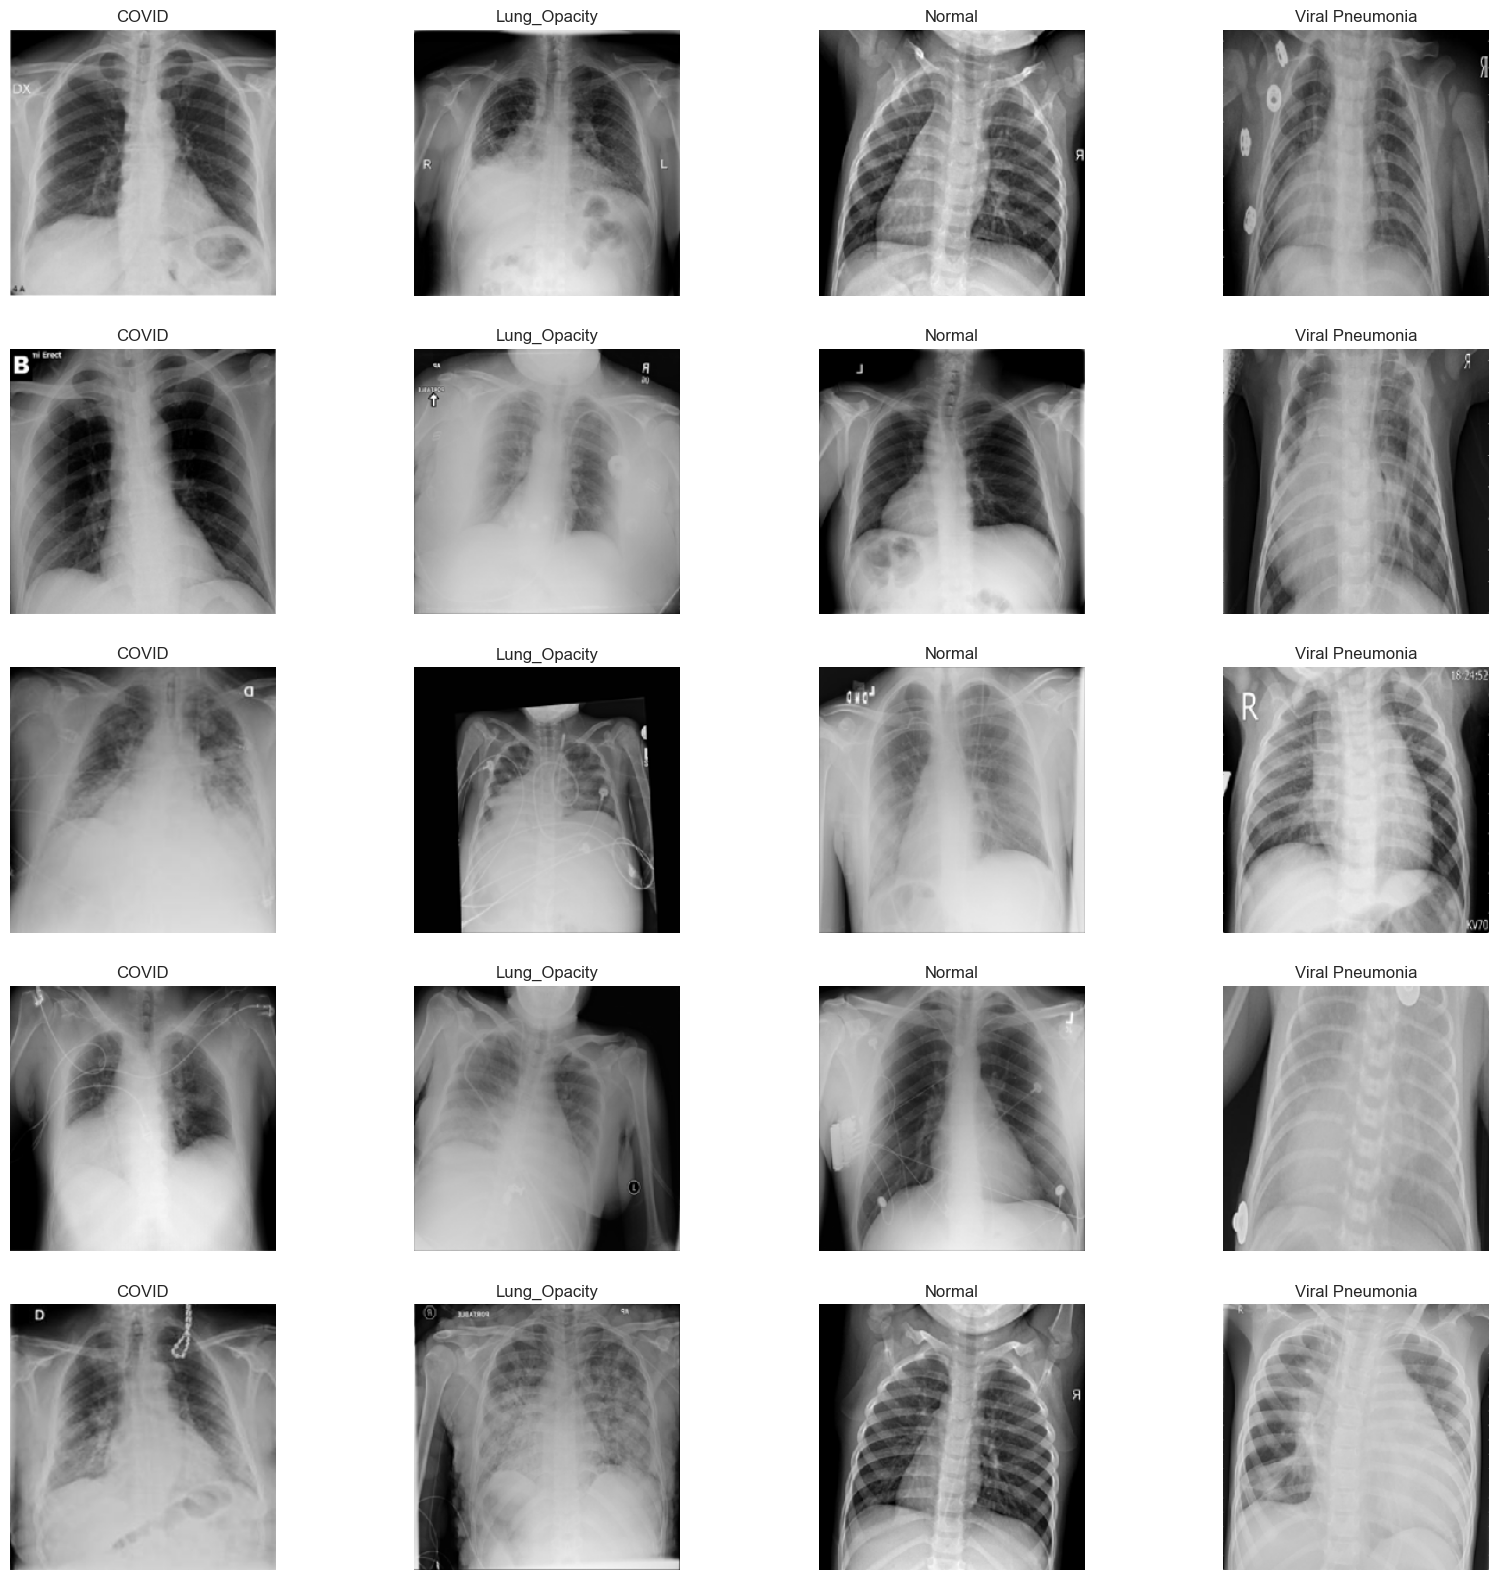

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Create a dictionary to store images for each class
class_images = {class_name: [] for class_name in class_names}

# Loop over the samples until 5 images per class are found
while True:
    images, labels = next(train_gen)
    for j in range(len(labels)):
        class_name = class_names[np.argmax(labels[j])]
        if len(class_images[class_name]) < 5:
            class_images[class_name].append(images[j])

    # Stop once 5 images per class are found
    if all(len(images) == 5 for images in class_images.values()):
        break

# Create a figure with 5 rows and N columns
fig, axs = plt.subplots(5, num_classes, figsize=(20, 20))

# Loop over the classes and plot the corresponding images
for i in range(num_classes):
    for j in range(5):
        axs[j, i].imshow(class_images[class_names[i]][j]/255)
        axs[j, i].set_title(class_names[i])
        axs[j, i].axis('off')

plt.show()

In [ ]:
Set the batch size, image size, and number of classes
batch_size = 16
img_height, img_width = 224, 224 num_classes = len(train_gen.class_indices)

Define the LeNet model
model = Sequential() model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3))) model.add(MaxPooling2D(pool_size=(2, 2))) model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) model.add(MaxPooling2D(pool_size=(2, 2))) model.add(Flatten()) model.add(Dense(128, activation='relu')) model.add(Dropout(0.5)) model.add(Dense(num_classes, activation='softmax'))

Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Set the batch size, image size, and number of classes
batch_size = 16
img_height, img_width = 224, 224
num_classes = len(train_gen.class_indices)


# Define the LeNet model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 average_pooling2d_2 (Avera  (None, 111, 111, 32)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 average_pooling2d_3 (Avera  (None, 54, 54, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 346112)           

In [16]:
# Train the model
history = model.fit(
    train_gen,
    epochs=20,
    callbacks = early_stop,
    validation_data=valid_gen,)

Epoch 1/20
1059/1059 [==============================] - 1959s 2s/step - loss: 9.1369 - accuracy: 0.5228 - val_loss: 0.9871 - val_accuracy: 0.5699
Epoch 2/20
1059/1059 [==============================] - 1789s 2s/step - loss: 0.9589 - accuracy: 0.5710 - val_loss: 0.9510 - val_accuracy: 0.5638
Epoch 3/20
1059/1059 [==============================] - 20905s 20s/step - loss: 0.8426 - accuracy: 0.6270 - val_loss: 0.8552 - val_accuracy: 0.6593
Epoch 4/20
1059/1059 [==============================] - 1996s 2s/step - loss: 0.8031 - accuracy: 0.6615 - val_loss: 0.8954 - val_accuracy: 0.6446
Epoch 5/20
1059/1059 [==============================] - 1681s 2s/step - loss: 0.7862 - accuracy: 0.6655 - val_loss: 0.8860 - val_accuracy: 0.6385
Epoch 6/20
1059/1059 [==============================] - 1587s 1s/step - loss: 0.6522 - accuracy: 0.7351 - val_loss: 0.6827 - val_accuracy: 0.7297
Epoch 7/20
1059/1059 [==============================] - 1617s 2s/step - loss: 0.7657 - accuracy: 0.7005 - val_loss: 1.0211

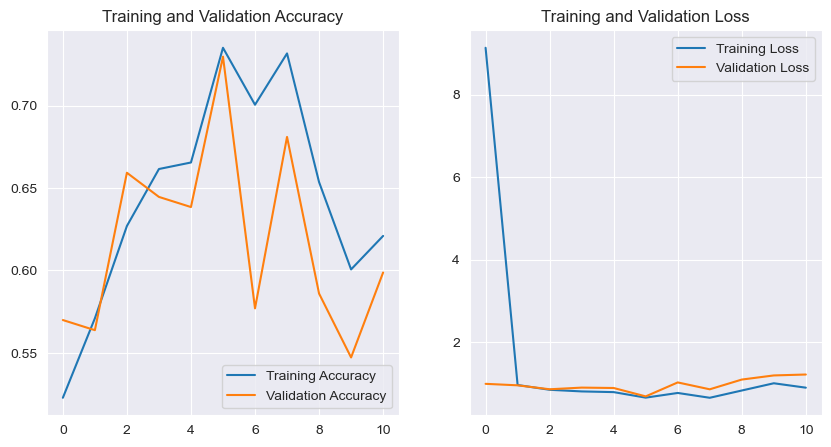

In [17]:
# Plot the training and validation accuracy over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc)) #Change with the number of epochs

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.save('LeNet_Saved.h5')

In [19]:
model = keras.models.load_model('LeNet_Saved.h5')

In [20]:
model.evaluate(test_gen)

29/29 [==============================] - 60s 2s/step - loss: 0.6716 - accuracy: 0.7402


[0.6716446876525879, 0.7401983737945557]

In [21]:
preds = model.predict_generator(test_gen)

In [22]:
y_pred = np.argmax(preds, axis=1)

In [23]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

In [26]:
cr = classification_report(test_gen.classes, y_pred)

In [27]:
classes

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [28]:
cm

array([[218,  55,  84,   5],
       [ 36, 453, 106,   7],
       [ 52, 161, 797,   9],
       [  4,  13,  18,  99]], dtype=int64)

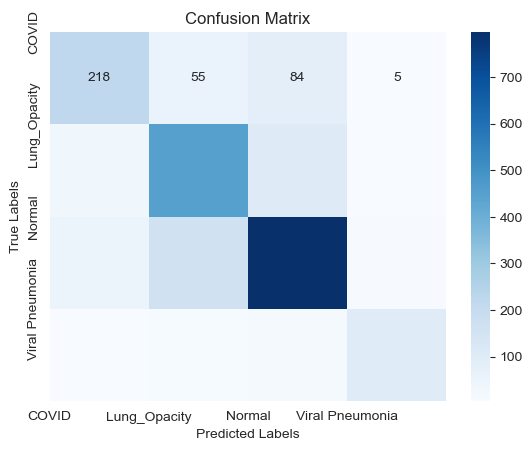

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_true and y_pred are the true and predicted labels, respectively


# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and ticks to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1, 2, 3], labels=classes)
plt.yticks(ticks=[0, 1, 2, 3], labels=classes)
plt.show()


In [30]:
print(cr)

              precision    recall  f1-score   support

           0       0.70      0.60      0.65       362
           1       0.66      0.75      0.71       602
           2       0.79      0.78      0.79      1019
           3       0.82      0.74      0.78       134

    accuracy                           0.74      2117
   macro avg       0.75      0.72      0.73      2117
weighted avg       0.74      0.74      0.74      2117



In [31]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
